In this notebook, we consider a ZDT1 problem with Gaussian noise, and benckmark two "denoising" methods:
* a naive average method,
* the KNN-Avg algorithm.

In [1]:
import nmoo

The first step is to construct our problem pipelines. We start with a `ZDT1` instance, that we wrap in a `ProblemWrapper`. In nmoo, `ProblemWrapper` is the base class to modify problems, in our case adding and removing noise. Additionally, `ProblemWrapper` and classes deriving from it maintain a history of every call made to their `_evaluate` method (see the [pymoo documentation](https://pymoo.org/getting_started.html#By-Class)).

Next, we add a Gaussian noise of type `N(0, 0.25)` and the averaging algorithm.

In [2]:
from pymoo.problems.multi import ZDT1
import numpy as np

zdt1 = ZDT1()
wrapped_zdt1 = nmoo.WrappedProblem(zdt1)
mean = np.array([0, 0])
covariance = np.array([[1., -.5], [-.5, 1]])
noisy_zdt1 = nmoo.noises.GaussianNoise(
    wrapped_zdt1, 
    {"F": (mean, covariance)},
)
avg_zdt1 = nmoo.denoisers.ResampleAverage(noisy_zdt1, n_evaluations=10)

We construct a similar pipeline for the KNN-Avg algorithm. Note that parts of
an already existing pipeline can be reused.

In [3]:

knnavg_zdt1 = nmoo.denoisers.KNNAvg(
    noisy_zdt1,
    distance_weight_type="squared",
    max_distance=1.0,
    n_neighbors=100,
)

Now, we setup an algorithm that will try and solve our `avg_zdt1` and `knnavg_zdt1` problems.

In [4]:
from pymoo.algorithms.moo.nsga2 import NSGA2

nsga2 = NSGA2(
    pop_size=40,
    n_offsprings=10,
    eliminate_duplicates=True,
)

Finally, we setup our benchmark. It will run NSGA2 against `avg_zdt1` and `knnavg_zdt1` five times each. Additionally, we specify a Pareto front population to measure the performance, not of NSGA2, but of KNN-Avg against the averaging method.

In [5]:
from pymoo.factory import get_termination

pareto_front = zdt1.pareto_front(100)

benchmark = nmoo.benchmark.Benchmark(
    output_dir_path="./out",
    problems={
        "knnavg": {
            "problem": knnavg_zdt1,
            "pareto_front": pareto_front,
        },
        "avg": {
            "problem": avg_zdt1,
            "pareto_front": pareto_front,
        },
    },
    algorithms={
        "nsga2": {
            "algorithm": nsga2,
        },
        "nsga2_10": {
            "algorithm": nsga2,
            "termination": get_termination("n_gen", 10),
        },
        "nsga2_100": {
            "algorithm": nsga2,
            "termination": get_termination("n_gen", 100),
        },
    },
    n_runs=3,
)

In [6]:
! (mkdir ./out; rm out/*) > /dev/null 2>&1

In [7]:
%%time
benchmark.run(verbose=50)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done   4 out of  18 | elapsed:    3.4s remaining:   11.9s
[Parallel(n_jobs=-1)]: Done   5 out of  18 | elapsed:    3.5s remaining:    9.0s
[Parallel(n_jobs=-1)]: Done   6 out of  18 | elapsed:    3.9s remaining:    7.8s
[Parallel(n_jobs=-1)]: Done   7 out of  18 | elapsed:   12.4s remaining:   19.5s
[Parallel(n_jobs=-1)]: Done   8 out of  18 | elapsed:   13.0s remaining:   16.2s
[Parallel(n_jobs=-1)]: Done   9 out of  18 | elapsed:   15.6s remaining:   15.6s
[Parallel(n_jobs=-1)]: Done  10 out of  18 | elapsed:   17.8s remaining:   14.2s
[Parallel(n_jobs=-1)]: Done  11 out of  18 | elapsed:   21.4s remaining:   13.6s
[Parallel(n_jobs=-1)]: Done  12 out of  18 | elapsed:   22.1s remaining:   11.1s
[Parallel

Results of the benchmark are automatically saved:

In [ ]:
! ls -1 ./out

avg.nsga2.1.1-resample_avg.npz
avg.nsga2.1.2-gaussian_noise.npz
avg.nsga2.1.3-wrapped_problem.npz
avg.nsga2.2.1-resample_avg.npz
avg.nsga2.2.2-gaussian_noise.npz
avg.nsga2.2.3-wrapped_problem.npz
avg.nsga2.3.1-resample_avg.npz
avg.nsga2.3.2-gaussian_noise.npz
avg.nsga2.3.3-wrapped_problem.npz
avg.nsga2_10.1.1-resample_avg.npz
avg.nsga2_10.1.2-gaussian_noise.npz
avg.nsga2_10.1.3-wrapped_problem.npz
avg.nsga2_10.2.1-resample_avg.npz
avg.nsga2_10.2.2-gaussian_noise.npz
avg.nsga2_10.2.3-wrapped_problem.npz
avg.nsga2_10.3.1-resample_avg.npz
avg.nsga2_10.3.2-gaussian_noise.npz
avg.nsga2_10.3.3-wrapped_problem.npz
avg.nsga2_100.1.1-resample_avg.npz
avg.nsga2_100.1.2-gaussian_noise.npz
avg.nsga2_100.1.3-wrapped_problem.npz
avg.nsga2_100.2.1-resample_avg.npz
avg.nsga2_100.2.2-gaussian_noise.npz
avg.nsga2_100.2.3-wrapped_problem.npz
avg.nsga2_100.3.1-resample_avg.npz
avg.nsga2_100.3.2-gaussian_noise.npz
avg.nsga2_100.3.3-wrapped_problem.npz
benchmark.csv
knnavg.nsga2.1.1-knn_avg.npz
knnavg.nsga2

The benchmark results are saved in `benchmark.csv`. They can also be accessed by `benchmark._results`. The rest are problem call histories, named after the following scheme:
```
<problem_name>.<algorithm_name>.<n_run>.<level>-<layer_name>.npz
```
For example, `knnavg.nsga2_100.3.2-gaussian_noise.npz` is the `GaussianNoise` history (level 2) of the 3rd run of `NSGA2` (100 generations) on the `knnavg` pipeline.

Let's now visualize the results. The final result of all runs can be found using the `Benchmark.final_results` method:

In [ ]:
benchmark.final_results()

,algorithm,problem,n_run,n_gen,timedelta,perf_gd,perf_gd+,perf_igd,perf_igd+
0,nsga2,avg,1,240,656299,1.331373,1.292831,0.595182,0.595182
1,nsga2,avg,2,239,271246,1.569757,1.537632,1.098642,1.094957
2,nsga2,avg,3,240,546441,0.800020,0.756240,0.307375,0.307361
3,nsga2,knnavg,1,180,851579,1.509993,1.270611,0.292886,0.285628
4,nsga2,knnavg,2,360,833483,1.674628,1.322090,0.112567,0.061472
5,nsga2,knnavg,3,260,386418,2.089736,1.660224,0.179841,0.060847
6,nsga2_10,avg,1,10,241300,2.606226,2.602994,1.681357,1.676689
7,nsga2_10,avg,2,10,234918,2.693826,2.690697,1.877986,1.877986
8,nsga2_10,avg,3,10,215878,2.574252,2.571444,1.930997,1.930997
9,nsga2_10,knnavg,1,10,747437,2.349880,2.291670,1.549868,1.549313


The following boxplot indicates that, with the same number of calls to `ZDT1`, KNN-Avg offers a better GD+ performance. However, on the number of generation is fixed or unconstrained, then the averaging method is better.

<AxesSubplot:xlabel='problem', ylabel='perf_gd+'>

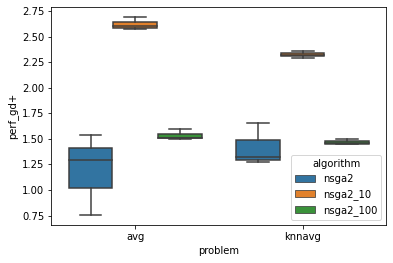

In [ ]:
import seaborn as sns

sns.boxplot(
    x="problem", 
    y="perf_gd+", 
    hue="algorithm",
    data=benchmark.final_results(),
)

The following boxplot depicts the runtimes.

<AxesSubplot:xlabel='problem', ylabel='timedelta'>

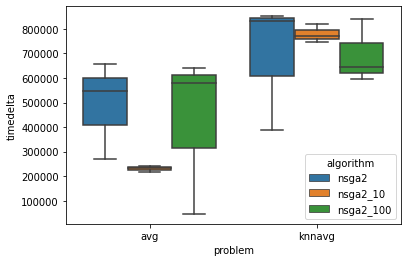

In [ ]:
sns.boxplot(
    x="problem", 
    y="timedelta", 
    hue="algorithm",
    data=benchmark.final_results(),
)